In [1]:

import uesgraphs as ug

from uesgraphs.examples import e1_example_readme as e1

import os
import sys
from datetime import datetime
import tempfile

In [2]:
import uesgraphs.analysis as analysis


In [3]:

workspace = e1.workspace_example("e14")

dir_ues = os.path.dirname(os.path.dirname(workspace))
pinola_json = os.path.join(dir_ues, "workspace", "e11", "inputs","test_modelgen", "Pinola", "nodes.json")
pinola_sim_data = os.path.join(dir_ues,"uesgraphs","data","Pinola_low_temp_network_inputs.mat")
pinola_sim_data = r"E:\rka_lko\work\2025_04_analysis\10042025SeestadtNewSim\Sim20250409_190504_detailed\Sim20250409_190504_1\Results\Sim20250409_190504_1_inputs.gzip"
pinola_json =r"E:\rka_lko\git\transurban_seestadt\dhc_model\workspace\transurban_seestadt_uesgraphs.json"
sysm_model = r"E:\rka_lko\git\transurban_seestadt\dhc_model\workspace\model.json"
if not os.path.exists(pinola_json):
    raise FileNotFoundError(f"File {pinola_json} not found."
                            "Please run example e11 to generate network topology.")


In [4]:
time_interval = "15min"
aixlib_version = "2.1.0"

graph = ug.UESGraph()
graph.from_json(path = pinola_json, network_type="heating")
graph.graph["name"] = "pinola"
graph.graph["supply_type"] = "supply"



read nodes...
******
 input_ids were {'buildings': None, 'nodes': 'f607cb63-8aed-446c-9970-9cd8380434f8', 'pipes': None, 'supplies': None}
...finished


In [23]:
graph.edges[1001,1006]

{'diameter': 0.2101,
 'length': 40.10060652984215,
 'pipeID': '10021014',
 'name': '10021014',
 'node_0': 1002,
 'node_1': 1014,
 'm_flow': DateTime
 2024-01-01 00:00:00   -1.839387e-14
 2024-01-01 00:15:00    7.673894e+00
 2024-01-01 00:30:00    7.706192e+00
 2024-01-01 00:45:00    7.636544e+00
 2024-01-01 01:00:00    6.587033e+00
                            ...     
 2024-01-06 23:00:00    4.114639e+00
 2024-01-06 23:15:00    4.434352e+00
 2024-01-06 23:30:00    4.977651e+00
 2024-01-06 23:45:00    4.601973e+00
 2024-01-07 00:00:00    6.023778e+00
 Freq: 15min, Name: networkModel.pipe10021014.port_a.m_flow, Length: 577, dtype: float32,
 'dp': DateTime
 2024-01-01 00:00:00     0.000000
 2024-01-01 00:15:00    67.377701
 2024-01-01 00:30:00    67.946053
 2024-01-01 00:45:00    66.723419
 2024-01-01 01:00:00    49.643723
                          ...    
 2024-01-06 23:00:00    19.370827
 2024-01-06 23:15:00    22.498056
 2024-01-06 23:30:00    28.348719
 2024-01-06 23:45:00    24.23107

In [6]:

start_date=datetime(2024, 1, 1) 
end_date=datetime(2024, 1, 7)
    
from uesgraphs.analysis.data_handling.data_handling import assign_data_pipeline

assign_data_pipeline(graph, pinola_sim_data, time_interval= time_interval,
                     aixlib_version=aixlib_version,
                     start_date=start_date, end_date=end_date,
                     system_model_path=sysm_model)

Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\3\assign_data_pipeline_20250829_100733.log
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\3\SystemModelHeating_20250829_100733.log
Model loaded from E:\rka_lko\git\transurban_seestadt\dhc_model\workspace\model.json


<uesgraphs.UESGraph object>

In [34]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Union, Optional

def check_pressure_consistency(graph, tolerance: float = 1e-6) -> Dict:
    """
    Überprüft die Konsistenz zwischen Druckdifferenzen der Kanten (dp) 
    und Druckunterschieden der verbundenen Knoten (pressure).
    
    Args:
        graph: uesgraph Objekt mit nodes und edges
        tolerance: Toleranz für numerische Vergleiche (Standard: 1e-6)
        
    Returns:
        Dict mit Ergebnissen der Konsistenzprüfung
    """
    results = {
        'consistent_edges': [],
        'inconsistent_edges': [],
        'errors': [],
        'summary': {}
    }
    
    inconsistent_count = 0
    total_edges = len(graph.edges)
    
    try:
        # Über alle Kanten iterieren
        for edge in graph.edges:
            try:
                # Verbundene Knoten finden
                # Annahme: edge ist ein Tuple (node1, node2) oder ähnlich
                if hasattr(edge, '__iter__') and len(edge) == 2:
                    node1, node2 = edge
                else:
                    # Falls edge anders strukturiert ist
                    node1 = graph.edges[edge].get('source', None)
                    node2 = graph.edges[edge].get('target', None)
                    
                    if node1 is None or node2 is None:
                        # Versuche NetworkX-ähnliche Struktur
                        edge_data = graph[edge[0]][edge[1]] if hasattr(graph, '__getitem__') else None
                        if edge_data:
                            node1, node2 = edge[0], edge[1]
                
                if node1 is None or node2 is None:
                    results['errors'].append(f"Konnte Knoten für Kante {edge} nicht finden")
                    continue
                
                # Druckwerte der Knoten abrufen
                pressure1 = graph.nodes[node1]["pressure"]
                pressure2 = graph.nodes[node2]["pressure"]
                
                # dp-Wert der Kante abrufen
                dp_edge = graph.edges[edge]["dp"]
                
                # Überprüfung für jeden Zeitpunkt (falls Zeitreihen)
                if hasattr(dp_edge, 'iloc'):  # pandas Series/DataFrame
                    for i in range(len(dp_edge)):
                        # Berechne erwartete Druckdifferenz
                        if hasattr(pressure1, 'iloc') and hasattr(pressure2, 'iloc'):
                            expected_dp = pressure1.iloc[i] - pressure2.iloc[i]
                            actual_dp = dp_edge.iloc[i]
                        else:
                            expected_dp = pressure1 - pressure2
                            actual_dp = dp_edge.iloc[i]
                        
                        # Konsistenzcheck mit Toleranz
                        if not np.isclose(actual_dp, expected_dp, atol=tolerance, rtol=tolerance):
                            inconsistent_count += 1
                            results['inconsistent_edges'].append({
                                'edge': edge,
                                'nodes': (node1, node2),
                                'timestep': i,
                                'expected_dp': expected_dp,
                                'actual_dp': actual_dp,
                                'difference': abs(actual_dp - expected_dp)
                            })
                        else:
                            results['consistent_edges'].append({
                                'edge': edge,
                                'nodes': (node1, node2),
                                'timestep': i
                            })
                else:
                    # Einzelwerte (keine Zeitreihe)
                    expected_dp = pressure1 - pressure2
                    actual_dp = dp_edge
                    
                    if not np.isclose(actual_dp, expected_dp, atol=tolerance, rtol=tolerance):
                        inconsistent_count += 1
                        results['inconsistent_edges'].append({
                            'edge': edge,
                            'nodes': (node1, node2),
                            'expected_dp': expected_dp,
                            'actual_dp': actual_dp,
                            'difference': abs(actual_dp - expected_dp)
                        })
                    else:
                        results['consistent_edges'].append({
                            'edge': edge,
                            'nodes': (node1, node2)
                        })
                        
            except Exception as e:
                results['errors'].append(f"Fehler bei Kante {edge}: {str(e)}")
    
    except Exception as e:
        results['errors'].append(f"Allgemeiner Fehler: {str(e)}")
    
    # Zusammenfassung erstellen
    results['summary'] = {
        'total_edges': total_edges,
        'consistent_edges_count': len(results['consistent_edges']),
        'inconsistent_edges_count': len(results['inconsistent_edges']),
        'errors_count': len(results['errors']),
        'consistency_ratio': len(results['consistent_edges']) / total_edges if total_edges > 0 else 0
    }
    
    return results

def get_edge_consistency_summary(results: Dict) -> pd.DataFrame:
    """
    Erstellt eine kompakte Übersicht der Konsistenz pro Kante.
    
    Args:
        results: Ergebnis der check_pressure_consistency Funktion
        
    Returns:
        DataFrame mit Konsistenz-Zusammenfassung pro Kante
    """
    # Debug: Schauen was in results ist
    print(f"DEBUG: consistent_edges count: {len(results['consistent_edges'])}")
    print(f"DEBUG: inconsistent_edges count: {len(results['inconsistent_edges'])}")
    print(f"DEBUG: errors count: {len(results['errors'])}")
    
    # Sammle alle Kanten
    all_edges = set()
    
    # Aus konsistenten Kanten
    for item in results['consistent_edges']:
        all_edges.add(item['edge'])
    
    # Aus inkonsistenten Kanten  
    for item in results['inconsistent_edges']:
        all_edges.add(item['edge'])
    
    print(f"DEBUG: all_edges count: {len(all_edges)}")
    
    # Falls keine Kanten gefunden wurden
    if not all_edges:
        print("WARNUNG: Keine Kanten für Konsistenzprüfung gefunden!")
        if results['errors']:
            print("Gefundene Fehler:")
            for error in results['errors']:
                print(f"  - {error}")
        return pd.DataFrame(columns=['Edge', 'Nodes', 'Status', 'Message'])
    
    summary_data = []
    
    for edge in all_edges:
        try:
            # Zähle konsistente Zeitschritte für diese Kante
            consistent_count = sum(1 for item in results['consistent_edges'] 
                                 if item['edge'] == edge)
            
            # Sammle inkonsistente Einträge für diese Kante
            inconsistent_items = [item for item in results['inconsistent_edges'] 
                                if item['edge'] == edge]
            inconsistent_count = len(inconsistent_items)
            
            total_count = consistent_count + inconsistent_count
            consistency_ratio = consistent_count / total_count if total_count > 0 else 0
            
            # Berechne Abweichungsstatistiken
            if inconsistent_items:
                deviations = [item['difference'] for item in inconsistent_items]
                max_deviation = max(deviations)
                avg_deviation = np.mean(deviations)
            else:
                max_deviation = 0.0
                avg_deviation = 0.0
            
            # Node-Namen extrahieren
            if inconsistent_items:
                nodes = inconsistent_items[0]['nodes']
            elif results['consistent_edges']:
                # Finde diese Kante in den konsistenten
                matching_consistent = [item for item in results['consistent_edges'] if item['edge'] == edge]
                if matching_consistent:
                    nodes = matching_consistent[0]['nodes']
                else:
                    nodes = ('?', '?')
            else:
                nodes = ('?', '?')
            
            summary_data.append({
                'Edge': str(edge),
                'Nodes': f"{nodes[0]} → {nodes[1]}",
                'Total_Timesteps': total_count,
                'Consistent': consistent_count,
                'Inconsistent': inconsistent_count,
                'Consistency_Rate_Display': f"{consistency_ratio:.1%}",
                'Consistency_Rate_Numeric': consistency_ratio,
                'Max_Deviation': max_deviation,
                'Avg_Deviation': avg_deviation,
                'Status': '✓' if inconsistent_count == 0 else '⚠' if consistency_ratio > 0.9 else '✗'
            })
        except Exception as e:
            print(f"FEHLER bei Kante {edge}: {e}")
            summary_data.append({
                'Edge': str(edge),
                'Nodes': 'ERROR',
                'Total_Timesteps': 0,
                'Consistent': 0,
                'Inconsistent': 0,
                'Consistency_Rate_Display': 'ERROR',
                'Consistency_Rate_Numeric': 0,
                'Max_Deviation': 0,
                'Avg_Deviation': 0,
                'Status': '✗'
            })
    
    if not summary_data:
        print("WARNUNG: Keine summary_data erstellt!")
        return pd.DataFrame(columns=['Edge', 'Nodes', 'Status', 'Message'])
    
    df = pd.DataFrame(summary_data)
    print(f"DEBUG: DataFrame created with {len(df)} rows")
    print(f"DEBUG: DataFrame columns: {list(df.columns)}")
    
    # Sortiere nach Konsistenz-Rate (schlechteste zuerst), nur wenn Spalte existiert
    if 'Consistency_Rate_Numeric' in df.columns and len(df) > 0:
        df = df.sort_values('Consistency_Rate_Numeric', ascending=True)
    
    # Entferne die numerische Spalte für die Anzeige
    if 'Consistency_Rate_Numeric' in df.columns:
        display_df = df.drop('Consistency_Rate_Numeric', axis=1)
        if 'Consistency_Rate_Display' in display_df.columns:
            display_df = display_df.rename(columns={'Consistency_Rate_Display': 'Consistency_Rate'})
        return display_df
    else:
        return df

def print_edge_summary(results: Dict):
    """
    Druckt eine kompakte Übersicht der Kantenkonsistenz.
    """
    df = get_edge_consistency_summary(results)
    
    print("=" * 100)
    print("KANTENKONSISTENZ ÜBERSICHT")
    print("=" * 100)
    
    # Gesamtstatistiken
    total_edges = len(df)
    fully_consistent = len(df[df['Inconsistent'] == 0])
    partially_consistent = len(df[(df['Inconsistent'] > 0) & (df['Consistency_Rate'] != '0.0%')])
    fully_inconsistent = len(df[df['Consistent'] == 0])
    
    print(f"Gesamte Kanten: {total_edges}")
    print(f"Vollständig konsistent (✓): {fully_consistent}")
    print(f"Teilweise konsistent (⚠): {partially_consistent}")  
    print(f"Vollständig inkonsistent (✗): {fully_inconsistent}")
    print()
    
    # Tabelle anzeigen (ohne Index)
    print(df.to_string(index=False))
    print()
    
    # Top 3 problematische Kanten
    worst_edges = df.head(3)
    if len(worst_edges) > 0 and worst_edges.iloc[0]['Inconsistent'] > 0:
        print("TOP 3 PROBLEMATISCHE KANTEN:")
        for _, row in worst_edges.iterrows():
            if row['Inconsistent'] > 0:
                print(f"  {row['Status']} {row['Edge']} ({row['Nodes']}): "
                      f"{row['Consistency_Rate']} konsistent, "
                      f"max. Abweichung: {row['Max_Deviation']:.6f}")
    
    print("=" * 100)

def print_consistency_report(results: Dict, show_details: bool = True):
    """
    Druckt einen formatierten Bericht der Konsistenzprüfung.
    
    Args:
        results: Ergebnis der check_pressure_consistency Funktion
        show_details: Zeigt Details zu inkonsistenten Kanten
    """
    print("=" * 60)
    print("DRUCKKONSISTENZ BERICHT")
    print("=" * 60)
    
    summary = results['summary']
    print(f"Gesamtanzahl Kanten: {summary['total_edges']}")
    print(f"Konsistente Kanten: {summary['consistent_edges_count']}")
    print(f"Inkonsistente Kanten: {summary['inconsistent_edges_count']}")
    print(f"Fehler: {summary['errors_count']}")
    print(f"Konsistenz-Rate: {summary['consistency_ratio']:.2%}")
    
    if results['errors']:
        print("\nFEHLER:")
        for error in results['errors']:
            print(f"  - {error}")
    
    if show_details and results['inconsistent_edges']:
        print("\nINKONSISTENTE KANTEN:")
        for item in results['inconsistent_edges']:
            edge_info = f"Kante {item['edge']} ({item['nodes'][0]} → {item['nodes'][1]})"
            if 'timestep' in item:
                print(f"  - {edge_info}, Zeitschritt {item['timestep']}")
            else:
                print(f"  - {edge_info}")
            print(f"    Erwartet: {item['expected_dp']:.6f}")
            print(f"    Tatsächlich: {item['actual_dp']:.6f}")
            print(f"    Abweichung: {item['difference']:.6f}")
    
    print("=" * 60)

# Beispiel für die Verwendung:
def fix_inconsistent_pressures(graph, results: Dict, method: str = 'adjust_dp'):
    """
    Behebt Inkonsistenzen basierend auf der gewählten Methode.
    
    Args:
        graph: uesgraph Objekt
        results: Ergebnis der Konsistenzprüfung
        method: 'adjust_dp' oder 'adjust_pressure'
    """
    if method == 'adjust_dp':
        # Passe dp-Werte der Kanten an die Druckdifferenzen an
        for item in results['inconsistent_edges']:
            edge = item['edge']
            expected_dp = item['expected_dp']
            
            if 'timestep' in item:
                graph.edges[edge].dp.iloc[item['timestep']] = expected_dp
            else:
                graph.edges[edge].dp = expected_dp
                
        print(f"dp-Werte von {len(results['inconsistent_edges'])} Kanten korrigiert.")
        
    elif method == 'adjust_pressure':
        print("Warnung: Druckanpassung ist komplex und kann andere Inkonsistenzen verursachen.")
        print("Diese Methode ist noch nicht implementiert.")
    
    else:
        print(f"Unbekannte Methode: {method}")

# Hauptfunktion für einfache Nutzung
def run_consistency_check(graph, tolerance: float = 1e-6, show_report: bool = True, compact_view: bool = True):
    """
    Führt eine komplette Konsistenzprüfung durch.
    
    Args:
        graph: uesgraph Objekt
        tolerance: Numerische Toleranz
        show_report: Zeige Bericht an
        compact_view: Verwende kompakte Ansicht (empfohlen) statt detaillierter Ausgabe
    """
    results = check_pressure_consistency(graph, tolerance)
    
    if show_report:
        if compact_view:
            print_edge_summary(results)
        else:
            print_consistency_report(results)
    
    return results

In [45]:
for edge in graph.edges:
    node1, node2 = list(edge)
    graph.edges[edge]["dp_calc"] = graph.nodes[node1]["pressure"] - graph.nodes[node2]["pressure"]
max((graph.edges[edge]["dp_calc"] - graph.edges[edge]["dp"])/graph.edges[edge]["dp"])

nan

In [52]:
# Finde starke Ausreißer in Druckdifferenzen
import numpy as np

# Bestimme die Anzahl der Zeitpunkte
first_edge = next(iter(graph.edges))
n_timesteps = len(graph.edges[first_edge]["dp"])

print("=== Starke Ausreißer in Druckdifferenzen ===")

for t in range(n_timesteps):
    outliers_found = False
    
    for edge in graph.edges:
        node1, node2 = list(edge)
        
        # Druckwerte an den Knoten
        p1 = graph.nodes[node1]["pressure"].iloc[t]
        p2 = graph.nodes[node2]["pressure"].iloc[t]
        
        # Berechnete und simulierte Druckdifferenz
        dp_calc = p1 - p2
        dp_sim = graph.edges[edge]["dp"].iloc[t]
        
        abs_diff = abs(dp_calc - dp_sim)
        
        # Nur starke Ausreißer (>0.1 Pa)
        if abs_diff > 0.1:
            if not outliers_found:
                print(f"\n--- Zeitpunkt {t} ---")
                outliers_found = True
            
            # Relative Abweichung bezogen auf absolute Druckwerte
            rel_to_p1 = abs_diff / abs(p1) * 100 if p1 != 0 else np.inf
            rel_to_p2 = abs_diff / abs(p2) * 100 if p2 != 0 else np.inf
            rel_to_dp_sim = abs_diff / abs(dp_sim) * 100 if dp_sim != 0 else np.inf
            
            print(f"Edge {edge}:")
            print(f"  Drücke: p1={p1:.2f} Pa, p2={p2:.2f} Pa")
            print(f"  DP: berechnet={dp_calc:.6f} Pa, simuliert={dp_sim:.6f} Pa")
            print(f"  Abweichung: {abs_diff:.6f} Pa")
            print(f"  Relativ zu p1: {rel_to_p1:.3f}%")
            print(f"  Relativ zu p2: {rel_to_p2:.3f}%") 
            print(f"  Relativ zu dp_sim: {rel_to_dp_sim:.3f}%")
            print()

=== Starke Ausreißer in Druckdifferenzen ===

--- Zeitpunkt 7 ---
Edge (1001, 1006):
  Drücke: p1=15964607.00 Pa, p2=15964432.00 Pa
  DP: berechnet=175.000000 Pa, simuliert=175.108414 Pa
  Abweichung: 0.108414 Pa
  Relativ zu p1: 0.000%
  Relativ zu p2: 0.000%
  Relativ zu dp_sim: 0.062%

Edge (1002, 1003):
  Drücke: p1=15963605.00 Pa, p2=15964232.00 Pa
  DP: berechnet=-627.000000 Pa, simuliert=-627.298584 Pa
  Abweichung: 0.298584 Pa
  Relativ zu p1: 0.000%
  Relativ zu p2: 0.000%
  Relativ zu dp_sim: 0.048%

Edge (1002, 1011):
  Drücke: p1=15963605.00 Pa, p2=15939134.00 Pa
  DP: berechnet=24471.000000 Pa, simuliert=24470.808594 Pa
  Abweichung: 0.191406 Pa
  Relativ zu p1: 0.000%
  Relativ zu p2: 0.000%
  Relativ zu dp_sim: 0.001%

Edge (1003, 1008):
  Drücke: p1=15964232.00 Pa, p2=15964333.00 Pa
  DP: berechnet=-101.000000 Pa, simuliert=-100.867912 Pa
  Abweichung: 0.132088 Pa
  Relativ zu p1: 0.000%
  Relativ zu p2: 0.000%
  Relativ zu dp_sim: 0.131%

Edge (1004, 1007):
  Drücke: p

<Axes: xlabel='DateTime'>

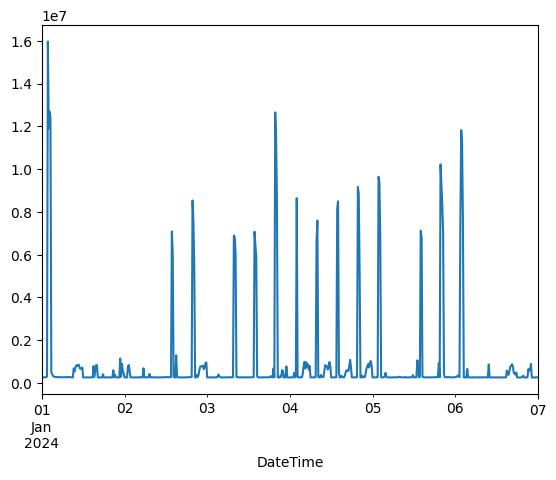

In [59]:
graph.nodes[1001]["pressure"].plot()

In [ ]:
def assess_dp_quality(graph, 
                      negligible_abs_threshold=1.0, 
                      negligible_rel_threshold=0.001,
                      acceptable_abs_threshold=10.0, 
                      acceptable_rel_threshold=0.01):
    """
    Bewertet die Qualität der Druckdifferenz-Berechnung für alle Kanten im Graphen.
    
    Parameters:
    -----------
    graph : uesgraph
        Das Fernwärmenetz-Graph-Objekt
    negligible_abs_threshold : float, default=1.0
        Absoluter Schwellwert für vernachlässigbare Abweichungen (Pa)
    negligible_rel_threshold : float, default=0.001
        Relativer Schwellwert für vernachlässigbare Abweichungen (0.1%)
    acceptable_abs_threshold : float, default=10.0
        Absoluter Schwellwert für akzeptable Abweichungen (Pa)
    acceptable_rel_threshold : float, default=0.01
        Relativer Schwellwert für akzeptable Abweichungen (1%)
    
    Returns:
    --------
    dict
        Dictionary mit den Kategorien 'negligible', 'acceptable', 'investigate'
        und den entsprechenden Kanten mit Zeitpunkt-Informationen
    """
    stats = {
        'negligible': [],
        'acceptable': [], 
        'investigate': []
    }
    
    for edge in graph.edges:
        node1, node2 = list(edge)
        p1 = graph.nodes[node1]["pressure"]
        p2 = graph.nodes[node2]["pressure"]
        dp_calc = p1 - p2
        dp_sim = graph.edges[edge]["dp"]
        
        # Prüfung für jeden Zeitpunkt
        for i in range(len(p1)):
            timestamp = p1.index[i] if hasattr(p1, 'index') else i
            
            diff_abs = abs(dp_calc.iloc[i] - dp_sim.iloc[i])
            rel_err = (diff_abs / abs(dp_sim.iloc[i]) 
                      if dp_sim.iloc[i] != 0 else float('inf'))
            
            edge_info = {
                'edge': edge,
                'timestamp': timestamp,
                'abs_diff': diff_abs,
                'rel_error': rel_err,
                'dp_calculated': dp_calc.iloc[i],
                'dp_simulated': dp_sim.iloc[i]
            }
            
            # Kategorisierung basierend auf Schwellwerten
            if (diff_abs < negligible_abs_threshold or 
                rel_err < negligible_rel_threshold):
                stats['negligible'].append(edge_info)
                
            elif (diff_abs < acceptable_abs_threshold and 
                  rel_err < acceptable_rel_threshold):
                stats['acceptable'].append(edge_info)
                
            else:
                stats['investigate'].append(edge_info)
    
    return stats


def print_dp_quality_summary(stats):
    """
    Gibt eine übersichtliche Zusammenfassung der Druckdifferenz-Qualitätsbewertung aus.
    
    Parameters:
    -----------
    stats : dict
        Ergebnis von assess_dp_quality()
    """
    total_measurements = (len(stats['negligible']) + 
                         len(stats['acceptable']) + 
                         len(stats['investigate']))
    
    print(f"\n=== Druckdifferenz-Qualitätsbewertung ===")
    print(f"Gesamtanzahl Messungen: {total_measurements}")
    print(f"Vernachlässigbar: {len(stats['negligible'])} ({len(stats['negligible'])/total_measurements*100:.1f}%)")
    print(f"Akzeptabel: {len(stats['acceptable'])} ({len(stats['acceptable'])/total_measurements*100:.1f}%)")
    print(f"Zu untersuchen: {len(stats['investigate'])} ({len(stats['investigate'])/total_measurements*100:.1f}%)")
    
    if stats['investigate']:
        print(f"\n--- Kritische Abweichungen (Top 5) ---")
        # Sortiere nach absolutem Fehler
        worst_cases = sorted(stats['investigate'], 
                           key=lambda x: x['abs_diff'], reverse=True)[:5]
        
        for case in worst_cases:
            print(f"Kante {case['edge']}, Zeit {case['timestamp']}: "
                  f"Δp_sim={case['dp_simulated']:.2f} Pa, "
                  f"Δp_calc={case['dp_calculated']:.2f} Pa, "
                  f"Diff={case['abs_diff']:.2f} Pa ({case['rel_error']*100:.2f}%)")


# Beispiel-Verwendung:
# stats = assess_dp_quality(graph, 
#                          negligible_abs_threshold=0.5,    # Strengere Toleranz
#                          acceptable_abs_threshold=5.0)
# print_dp_quality_summary(stats)

{'negligible': [(1001, 1005),
  (1001, 1006),
  (1001, 1009),
  (1002, 1003),
  (1002, 1004),
  (1002, 1011),
  (1003, 1008),
  (1004, 1007),
  (1005, 1013),
  (1006, 1008),
  (1006, 1010),
  (1007, 1012)],
 'acceptable': [],
 'investigate': []}

In [ ]:


from uesgraphs.systemmodels import utilities as ut
sysm_graph = ut.load_system_model_from_json(sysm_model)
from uesgraphs.analysis.data_handling import graph_transformation
port_mapping = graph_transformation.map_system_model_to_uesgraph(sysm_graph,graph)

logger = set_up_file_logger("all")
MASK = AIXLIB_MASKS[aixlib_version]
filter_list = build_filter_list_pipe(graph,mask=MASK,logger=logger)
m = validate_columns_exist(file_path=pinola_sim_data, required_columns=filter_list,logger=logger)

df = process_simulation_result(file_path=pinola_sim_data, filter_list=filter_list, logger=logger)
df = prepare_DataFrame(df, start_date=start_date, end_date=end_date, 
                             time_interval=time_interval, logger=logger)

assign_node_values(graph, df, port_mapping, MASK, logger=logger)
assign_edge_data(graph, MASK, df)

validate_graph_attributes(graph, MASK, df,logger=logger)

{'node_type': 'network_heating',
 'network_id': 'network_id',
 'position': <POINT (63.438 52.655)>,
 'name': 1002,
 'pressure': DateTime
 2024-01-01 00:00:00    250000.000000
 2024-01-01 00:15:00    263235.187500
 2024-01-01 00:30:00    263346.843750
 2024-01-01 00:45:00    263106.656250
 2024-01-01 01:00:00    259751.656250
                            ...      
 2024-01-06 23:00:00    253805.296875
 2024-01-06 23:15:00    254517.640625
 2024-01-06 23:30:00    255628.406250
 2024-01-06 23:45:00    254830.875000
 2024-01-07 00:00:00    258155.234375
 Freq: 15min, Name: networkModel.pipe10021010.port_a.p, Length: 577, dtype: float32,
 'temperature': DateTime
 2024-01-01 00:00:00    313.149994
 2024-01-01 00:15:00    316.139557
 2024-01-01 00:30:00    316.139618
 2024-01-01 00:45:00    316.139557
 2024-01-01 01:00:00    316.137970
                           ...    
 2024-01-06 23:00:00    316.128937
 2024-01-06 23:15:00    316.130432
 2024-01-06 23:30:00    316.132538
 2024-01-06 23:45:00

In [8]:
graph.edges[1001,1005]

{'diameter': 0.0697,
 'length': 62.67448664094058,
 'pipeID': '10021010',
 'name': '10021010',
 'node_0': 1002,
 'node_1': 1010,
 'm_flow': DateTime
 2024-01-01 00:00:00    1.839387e-14
 2024-01-01 00:15:00    1.884012e+00
 2024-01-01 00:30:00    1.891941e+00
 2024-01-01 00:45:00    1.874842e+00
 2024-01-01 01:00:00    1.617178e+00
                            ...     
 2024-01-06 23:00:00    1.010212e+00
 2024-01-06 23:15:00    1.100760e+00
 2024-01-06 23:30:00    1.228627e+00
 2024-01-06 23:45:00    1.138265e+00
 2024-01-07 00:00:00    1.478893e+00
 Freq: 15min, Name: networkModel.pipe10021010.port_a.m_flow, Length: 577, dtype: float32,
 'dp': DateTime
 2024-01-01 00:00:00       0.000000
 2024-01-01 00:15:00    2270.666504
 2024-01-01 00:30:00    2289.820312
 2024-01-01 00:45:00    2248.616943
 2024-01-01 01:00:00    1673.021484
                           ...     
 2024-01-06 23:00:00     652.846497
 2024-01-06 23:15:00     775.124146
 2024-01-06 23:30:00     965.664734
 2024-01-06 23

In [5]:
#gr = analysis.assign_simulation_data(graph, pinola_sim_data, start_date, end_date,aixlib_version="2.0.0",auto_retry=True)

In [6]:
from uesgraphs.systemmodels import utilities as ut
sysm_graph = ut.load_system_model_from_json(sysm_model)

Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\3\SystemModelHeating_20250828_184729.log
Model loaded from E:\rka_lko\git\transurban_seestadt\dhc_model\workspace\model.json


In [7]:
from uesgraphs.systemmodels import utilities as ut
sysm_graph = ut.load_system_model_from_json(sysm_model)
from uesgraphs.analysis.data_handling import graph_transformation
port_mapping = graph_transformation.map_system_model_to_uesgraph(sysm_graph,graph)

In [8]:
# 1. Supply Type und Masks laden
supply_type = graph.graph["supply_type"]  # "supply" oder "return"
supply_type_prefix = {"supply": "", "return": "R"}

from uesgraphs.analysis.data_handling.data_handling import get_MASKS
masks = get_MASKS("2.1.0")  # oder deine gewünschte Version

# 2. Filter-Liste bauen (wie im existierenden Code)
filter_list = []
for edge in graph.edges:
    pipe_code = graph.edges[edge]["name"]
    for mask_type, mask_pattern in masks.items():
        var_name = mask_pattern.format(
            pipe_code=pipe_code, 
            type=supply_type_prefix[supply_type]
        )
        filter_list.append(var_name)

print(f"Filter-Liste mit {len(filter_list)} Variablen:")
for var in filter_list[:10]:  # Erste 10 zeigen
    print(f"  - {var}")

# 3. Daten laden
from uesgraphs.analysis.data_handling.data_handling import process_simulation_result
df = process_simulation_result(file_path=pinola_sim_data, filter_list=filter_list)

print(f"\nDataFrame Shape: {df.shape}")
print(f"Spalten: {list(df.columns)}")

uesgraphs.analysis.data_handling.data_handling.get_MASKS - INFO - Using AixLib version 2.1.0 masks
uesgraphs.analysis.data_handling.data_handling.process_parquet_file - INFO - Found existing gzip file: E:\rka_lko\work\2025_04_analysis\10042025SeestadtNewSim\Sim20250409_190504_detailed\Sim20250409_190504_1\Results\Sim20250409_190504_1_inputs.gzip
uesgraphs.analysis.data_handling.data_handling.process_parquet_file - INFO - Validating 72 required columns in: E:\rka_lko\work\2025_04_analysis\10042025SeestadtNewSim\Sim20250409_190504_detailed\Sim20250409_190504_1\Results\Sim20250409_190504_1_inputs.gzip


Filter-Liste mit 72 Variablen:
  - networkModel.pipe10021010.port_a.m_flow
  - networkModel.pipe10021010.dp
  - networkModel.pipe10021010.port_a.p
  - networkModel.pipe10021010.port_b.p
  - networkModel.pipe10021010.sta_a.T
  - networkModel.pipe10021010.sta_b.T
  - networkModel.pipe10021014.port_a.m_flow
  - networkModel.pipe10021014.dp
  - networkModel.pipe10021014.port_a.p
  - networkModel.pipe10021014.port_b.p


uesgraphs.analysis.data_handling.data_handling.process_parquet_file - INFO - All required columns found in data file
uesgraphs.analysis.data_handling.data_handling.process_parquet_file - INFO - Starting parquet file processing: E:\rka_lko\work\2025_04_analysis\10042025SeestadtNewSim\Sim20250409_190504_detailed\Sim20250409_190504_1\Results\Sim20250409_190504_1_inputs.gzip
uesgraphs.analysis.data_handling.data_handling.process_parquet_file - INFO - Successfully loaded 35041 rows, 72 columns



DataFrame Shape: (35041, 72)
Spalten: ['networkModel.pipe10021010.port_a.m_flow', 'networkModel.pipe10021010.dp', 'networkModel.pipe10021010.port_a.p', 'networkModel.pipe10021010.port_b.p', 'networkModel.pipe10021010.sta_a.T', 'networkModel.pipe10021010.sta_b.T', 'networkModel.pipe10021014.port_a.m_flow', 'networkModel.pipe10021014.dp', 'networkModel.pipe10021014.port_a.p', 'networkModel.pipe10021014.port_b.p', 'networkModel.pipe10021014.sta_a.T', 'networkModel.pipe10021014.sta_b.T', 'networkModel.pipe10021025.port_a.m_flow', 'networkModel.pipe10021025.dp', 'networkModel.pipe10021025.port_a.p', 'networkModel.pipe10021025.port_b.p', 'networkModel.pipe10021025.sta_a.T', 'networkModel.pipe10021025.sta_b.T', 'networkModel.pipe10041006.port_a.m_flow', 'networkModel.pipe10041006.dp', 'networkModel.pipe10041006.port_a.p', 'networkModel.pipe10041006.port_b.p', 'networkModel.pipe10041006.sta_a.T', 'networkModel.pipe10041006.sta_b.T', 'networkModel.pipe10041007.port_a.m_flow', 'networkModel.pip

In [9]:
i = 1001
node_ports = port_mapping[i]  # Liste aller Ports für diesen Node
collected_values = {"T": [], "p": []}

# Mapping für flexible Attributnamen im Graph
attribute_names = {"T": "temperature", "p": "press_flow"}  # Konfigurierbar!

for port in node_ports:  # Iteriere über ALLE Ports des Nodes
    port_splitted = port.split(".")
    if port_splitted[1].endswith("a"):
        #port is an a port
        temp = f"networkModel.{port_splitted[0]}.sta_a.T"
        press = f"networkModel.{port_splitted[0]}.port_a.p"
        t_value = df[temp].iloc[0]
        p_value = df[press].iloc[0]
        collected_values["T"].append(t_value)
        collected_values["p"].append(p_value)

# Validiere und weise zu
for size in ["T", "p"]:
    unique_vals = set(collected_values[size])
    if len(unique_vals) != 1:
        raise ValueError(f"Node {i}: Inkonsistente {size}-Werte gefunden: {collected_values[size]}")
    graph.nodes[i][attribute_names[size]] = collected_values[size][0]

In [10]:
print(f"Port Mapping für Knoten {i}: {port}")
pipe_mask = df.columns.str.contains('pipe10021014.')
df_pipe = df.loc[:, pipe_mask]
print(f"Gefundene Spalten: {df.columns[pipe_mask].tolist()}")

Port Mapping für Knoten 1001: pipe10021025.port_a
Gefundene Spalten: ['networkModel.pipe10021014.port_a.m_flow', 'networkModel.pipe10021014.dp', 'networkModel.pipe10021014.port_a.p', 'networkModel.pipe10021014.port_b.p', 'networkModel.pipe10021014.sta_a.T', 'networkModel.pipe10021014.sta_b.T']


In [11]:
edges = list(graph.edges)
for edge in edges:
    print(f"Edge {edge} has data: {graph.edges[edge]}")

Edge (1001, 1005) has data: {'diameter': 0.0697, 'length': 62.67448664094058, 'pipeID': '10021010', 'name': '10021010', 'node_0': 1002, 'node_1': 1010}
Edge (1001, 1006) has data: {'diameter': 0.2101, 'length': 40.10060652984215, 'pipeID': '10021014', 'name': '10021014', 'node_0': 1002, 'node_1': 1014}
Edge (1001, 1009) has data: {'diameter': 0.2101, 'length': 23.793988913832845, 'pipeID': '10021025', 'name': '10021025', 'node_0': 1002, 'node_1': 'supply1'}
Edge (1002, 1003) has data: {'diameter': 0.1325, 'length': 23.15227945754485, 'pipeID': '10041006', 'name': '10041006', 'node_0': 1004, 'node_1': 1006}
Edge (1002, 1004) has data: {'diameter': 0.1325, 'length': 67.21343661070965, 'pipeID': '10041007', 'name': '10041007', 'node_0': 1004, 'node_1': 1007}
Edge (1002, 1011) has data: {'diameter': 0.0539, 'length': 25.20026053450003, 'pipeID': '10041027', 'name': '10041027', 'node_0': 1004, 'node_1': 'w11_2'}
Edge (1003, 1008) has data: {'diameter': 0.2101, 'length': 43.10762795752977, '

In [12]:
    graph = analyze.assign_data_to_uesgraphs(graph,sim_data = pinola_sim_data,
                                             start_date=start_date,
                                             end_date=end_date,
                                             aixlib_version="2.1.0") #aixlib version is needed to assign data properly
    
    ### Plotting
    #Visuals cant handle series data, so we just take the mean values, but single time points are possible
    vis = ug.Visuals(graph)
    for edge in graph.edges:
        graph.edges[edge]["m_flow_mean"] = graph.edges[edge]["m_flow"].mean()
    vis.show_network(show_plot=False,
                           scaling_factor=1,
                           scaling_factor_diameter=50,
                           label_size=15,
                           ylabel="Mean mass flow [kg/s]",
                           generic_extensive_size="m_flow_mean",
                           save_as=os.path.join(workspace, "m_flow.png"),
                           timestamp=f"{graph.graph["name"]}: Mean mass flow"
                           )
    
    for node in graph.nodes:
        graph.nodes[node]["press_flow_mean"] = graph.nodes[node]["press_flow"].mean()
    vis.show_network(show_plot=False,
                           scaling_factor=1,
                           scaling_factor_diameter=50,
                           ylabel="Mean pressure [Pa]",
                           label_size=15,
                           generic_intensive_size="press_flow_mean",
                           save_as=os.path.join(workspace, "press_flow.png"),
                           timestamp=f"{graph.graph["name"]}: Mean pressure flow"
                           )
    
    df = analyze.pump_power_analysis(graph, True, r"D:\rka-lko\work\2025_04_analysis\3")

if __name__ == "__main__":
    main()

IndentationError: unexpected indent (2453415739.py, line 1)

# New flow

In [27]:
AIXLIB_MASKS = {
    "2.1.0": {
        "edge": {
            # Extensive properties - same value at both ports
            "m_flow": "networkModel.pipe{pipe_code}{type}.port_a.m_flow",
            "dp": "networkModel.pipe{pipe_code}{type}.dp",
        },
        "node": {
            # Intensive properties - may differ between ports
            "pressure": {
                "port_a": "networkModel.pipe{pipe_code}{type}.port_a.p",
                "port_b": "networkModel.pipe{pipe_code}{type}.port_b.p"
            },
            "temperature": {
                "port_a": "networkModel.pipe{pipe_code}{type}.sta_a.T", 
                "port_b": "networkModel.pipe{pipe_code}{type}.sta_b.T"
            }
        }
    },
    "2.0.0": {
        "edge": {
            # Extensive properties - same value at both ports
            "m_flow": "networkModel.pipe{pipe_code}{type}.port_a.m_flow",
        },
        "node": {
            # Intensive properties - may differ between ports
            "pressure": {
                "port_a": "networkModel.pipe{pipe_code}{type}.port_a.p",
                "port_b": "networkModel.pipe{pipe_code}{type}.ports_b[1].p"
            },
            "temperature": {
                "port_a": "networkModel.pipe{pipe_code}{type}.sta_a.T",
                "port_b": "networkModel.pipe{pipe_code}{type}.sta_b[1].T"
            }
        }
    }
}

In [28]:
def get_supply_type_prefix(graph):
    supply_type = graph.graph.get("supply_type", "supply")
    supply_type_prefix = {"supply": "", "return": "R"}
    return supply_type_prefix.get(supply_type, "")

def build_filter_list_pipe(graph,MASK, logger=None):
    if logger is None:
        import logging
        logger = logging.getLogger(__name__)
    mask_sim = []
    for category_name, category in MASK.items():
        if category_name in ["edge", "node"]:
            if category_name == "edge":
                # Edge values: direct access to patterns
                mask_sim.extend(category.values())
            else:  # node
                # Node values: nested structure - extract all port patterns
                for attribute_patterns in category.values():
                    mask_sim.extend(attribute_patterns.values())

    type_prefix = get_supply_type_prefix(graph)

    filter_list = []
    for edge in graph.edges:
        pipe_code = graph.edges[edge]["name"]
        for entry_sim in mask_sim:
            var_name = entry_sim.format(
                pipe_code=pipe_code, 
                type=type_prefix
            )
            filter_list.append(var_name)
    return filter_list



In [35]:
def build_filter_list_pipe(graph, mask, logger=None):
    """
    Build a list of filter variables for pipes in a district heating network graph.
    
    This function extracts patterns from a mask data structure and formats them
    with specific pipe codes and type information for each edge (pipe) in the graph.
    This is useful for filtering and analyzing district heating networks.
    
    Args:
        graph (networkx.Graph): NetworkX graph object representing the district 
                               heating network. Each edge should have a 'name' 
                               attribute (pipe code).
        mask (dict): Hierarchical data structure containing filter patterns.
                    Expected categories are 'edge' and 'node':
                    - 'edge': Dict with direct pattern values
                    - 'node': Dict with nested pattern values
        logger (logging.Logger, optional): Logger instance for debug output.
                                          Will be created automatically if None.
    
    Returns:
        list: List of formatted variable names for all pipes in the graph,
              based on the mask patterns.
    
    Example:
        >>> mask = {
        ...     'edge': {'pressure': 'p_{pipe_code}_{type}'},
        ...     'node': {'inlet': {'temp': 'T_in_{pipe_code}_{type}'}}
        ... }
        >>> filter_list = build_filter_list_pipe(graph, mask)
        >>> print(filter_list)
        ['p_PIPE001_supply', 'T_in_PIPE001_supply', ...]
    
    Raises:
        KeyError: If pipe edges don't have a 'name' attribute
        AttributeError: If graph doesn't have edges attribute
    """
    # Initialize logger if not provided
    if logger is None:
        logger = set_up_terminal_logger(__name__)
    
    # Collection of all simulation patterns from the mask structure
    simulation_patterns = []
    
    # Iterate through all categories in the mask
    for category_name, category_data in mask.items():
        if category_name not in ["edge", "node"]:
            logger.warning(f"Unknown category '{category_name}' in mask, skipping")
            continue
            
        if category_name == "edge":
            # Edge category: direct extraction of pattern values
            # Example: {'pressure': 'p_{pipe_code}_{type}'} -> ['p_{pipe_code}_{type}']
            simulation_patterns.extend(category_data.values())
            logger.debug(f"Added {len(category_data)} edge patterns")
            
        elif category_name == "node":
            # Node category: nested structure - extract all port patterns
            # Example: {'inlet': {'temp': 'T_in_{pipe_code}_{type}'}} 
            #          -> ['T_in_{pipe_code}_{type}']
            for port_name, attribute_patterns in category_data.items():
                if isinstance(attribute_patterns, dict):
                    simulation_patterns.extend(attribute_patterns.values())
                    logger.debug(f"Added {len(attribute_patterns)} node patterns "
                               f"for port '{port_name}'")
                else:
                    logger.warning(f"Expected dict for node port '{port_name}', "
                                 f"got {type(attribute_patterns)}")
    
    logger.info(f"Extracted {len(simulation_patterns)} simulation patterns total")
    
    # Get type prefix from graph (e.g., 'supply', 'return')
    type_prefix = get_supply_type_prefix(graph)
    logger.debug(f"Using type prefix: '{type_prefix}'")
    
    # List for all generated filter variables
    filter_variables = []
    
    # Generate filter variables for each edge (pipe) in the graph
    for edge in graph.edges:
        try:
            # Extract pipe code from edge attributes
            pipe_code = graph.edges[edge]["name"]
            
            # Generate a variable for each simulation pattern
            for pattern in simulation_patterns:
                # Format pattern with specific values
                variable_name = pattern.format(
                    pipe_code=pipe_code,
                    type=type_prefix
                )
                filter_variables.append(variable_name)
                
            logger.debug(f"Generated {len(simulation_patterns)} variables "
                        f"for pipe '{pipe_code}'")
                        
        except KeyError as e:
            logger.error(f"Edge {edge} missing required attribute: {e}")
            raise
        except Exception as e:
            logger.error(f"Error processing edge {edge}: {e}")
            raise
    
    logger.info(f"Created filter list with {len(filter_variables)} entries "
               f"for {len(graph.edges)} pipes")
    
    return filter_variables

build_filter_list_pipe(graph,mask=MASK,logger=logger)

['networkModel.pipe10021010.port_a.m_flow',
 'networkModel.pipe10021010.dp',
 'networkModel.pipe10021010.port_a.p',
 'networkModel.pipe10021010.port_b.p',
 'networkModel.pipe10021010.sta_a.T',
 'networkModel.pipe10021010.sta_b.T',
 'networkModel.pipe10021014.port_a.m_flow',
 'networkModel.pipe10021014.dp',
 'networkModel.pipe10021014.port_a.p',
 'networkModel.pipe10021014.port_b.p',
 'networkModel.pipe10021014.sta_a.T',
 'networkModel.pipe10021014.sta_b.T',
 'networkModel.pipe10021025.port_a.m_flow',
 'networkModel.pipe10021025.dp',
 'networkModel.pipe10021025.port_a.p',
 'networkModel.pipe10021025.port_b.p',
 'networkModel.pipe10021025.sta_a.T',
 'networkModel.pipe10021025.sta_b.T',
 'networkModel.pipe10041006.port_a.m_flow',
 'networkModel.pipe10041006.dp',
 'networkModel.pipe10041006.port_a.p',
 'networkModel.pipe10041006.port_b.p',
 'networkModel.pipe10041006.sta_a.T',
 'networkModel.pipe10041006.sta_b.T',
 'networkModel.pipe10041007.port_a.m_flow',
 'networkModel.pipe10041007.dp',

In [29]:

def assign_node_values(graph, df, port_mapping, mask, time_index=0, logger=None):
    """
    Assigns node values from simulation data using flexible mask configuration.
    
    Processes intensive properties (pressure, temperature) that may differ between 
    ports of the same pipe, unlike extensive properties (mass flow) that are 
    identical at both ports.
    
    Args:
        graph: NetworkX graph with nodes to assign values to
        df: DataFrame containing simulation data
        port_mapping: Dict mapping node_ids to list of connected ports.
                     Example: {1: ['pipe001.port_a', 'pipe002.port_b'], 
                              2: ['pipe001.port_b', 'pipe003.port_a']}
                     Source: [Method name if known, otherwise leave empty]
        mask: Mask dictionary containing node configuration for intensive properties
        time_index: Time step index to extract from df (default: 0)
        logger: Logger instance (optional, creates terminal logger if None)
    """
    if logger is None:
        logger = set_up_terminal_logger(f"{__name__}.assign_node_values")
    
    # Extract node configuration
    node_config = mask.get("node", {})
    if not node_config:
        logger.error("No 'node' configuration found in mask")
        return
    
    type_suffix = get_supply_type_prefix(graph)
    
    stats =  {
        'processed_count': 0,
        'inconsistency_count': 0, 
        'pattern_conflicts': 0
    }
    
    for node_id, node_ports in port_mapping.items():
        if not node_ports:
            continue
            
        _assign_attributes_to_node(
            graph, node_id, node_ports, df, node_config,
            type_suffix, stats, logger
        )
        
        stats['processed_count'] += 1
    
    logger.info(f"Assignment completed:")
    logger.info(f"  Processed nodes: {stats['processed_count']}")
    logger.info(f"  Within-pattern inconsistencies: {stats['inconsistency_count']}")
    logger.info(f"  Cross-pattern conflicts: {stats['pattern_conflicts']}")

def _assign_attributes_to_node(graph, node_id, node_ports, df, config, 
                              type_suffix, stats, logger):
    """Assign all attributes to a single node.
        config: {"attribute": {"port_suffix": "pattern_with_{pipe_code}"}}
                ex.: {"temperature": {"port_a": "networkModel.pipe{pipe_code}{type}.sta_a.T"}}
    """
    
    for attribute_name, port_patterns in config.items():
        """Collect values for a specific attribute from all relevant ports.
        attribute_name: e.g. "temperature"
        port_patterns: e.g. {"port_a": "networkModel.pipe{pipe_code}{type}.sta_a.T",
                        "port_b": "networkModel.pipe{pipe_code}{type}.sta_b.T"}
        """
        series_list = []
        for port in node_ports:
            
            pipe_name, port_suffix = _parse_port_identifier(port)
            if port_suffix in port_patterns:
                pattern = port_patterns[port_suffix]
                column_name = pattern.format(pipe_code=pipe_name, type=type_suffix)
            
                if column_name in df.columns:
                    series = df[column_name]
                    series_list.append(series)
                else:
                    logger.debug(f"Column not found: {column_name}")

        if len(series_list) == 0:
            logger.debug(f"No data found for {attribute_name} at node {node_id}")
            continue

        # Check if all series are identical
        if len(series_list) > 1:
            all_equal = all(series_list[0].equals(series) for series in series_list[1:])
            if not all_equal:
                logger.warning(f"Node {node_id}: Inconsistent {attribute_name} time series found")
                stats['inconsistency_count'] += 1
        
        # Use first series as result
        graph.nodes[node_id][attribute_name] = series_list[0]        

def _parse_port_identifier(port):
    """Parse port identifier to extract pipe name and port suffix."""
    port_parts = port.split(".")
    if len(port_parts) < 2:
        raise ValueError(f"Invalid port format: {port}. Expected 'pipe_name.port_suffix'")
    return port_parts[0].replace("pipe", ""), port_parts[1]


## Edges
def assign_edge_data(graph, MASK, df):
    type_suffix = get_supply_type_prefix(graph)
    for edge in graph.edges:
        for edge_variable, variable_mask in MASK["edge"].items():
            pipe_name = graph.edges[edge]["name"]
            variable_name = variable_mask.format(pipe_code=pipe_name, type=type_suffix)
            graph.edges[edge][edge_variable] = df[variable_name]
        
## validation
def validate_graph_attributes(graph, mask, reference_df, logger=None):
    """
    Validates graph edge and node attributes against a reference DataFrame.
    
    Checks if the length of attribute arrays in edges and nodes matches the 
    number of rows in the reference DataFrame.
    
    Args:
        graph: NetworkX Graph object with edges and nodes
        mask (dict): Dictionary with "edge" and "node" keys containing 
                    attributes to validate
        reference_df (pd.DataFrame): Reference DataFrame for length comparison
        logger (logging.Logger, optional): Logger instance. If None, a 
                                         terminal logger will be created.
    
    Returns:
        bool: True if all validations pass, False otherwise
        
    Raises:
        ValueError: For critical validation errors
    """
    if logger is None:
        logger = set_up_terminal_logger(f"{__name__}.validate_graph_attributes")
    
    logger.info("Starting graph attribute validation...")
    
    expected_length = reference_df.shape[0]
    validation_passed = True
    errors = []
    
    # Validate edge attributes
    logger.info(f"Validating edge attributes for {len(graph.edges)} edges...")
    
    if "edge" in mask:
        for edge_idx, edge in enumerate(graph.edges):
            for edge_attr in mask["edge"].keys():
                if edge_attr in graph.edges[edge]:
                    actual_length = len(graph.edges[edge][edge_attr])
                    
                    if actual_length != expected_length:
                        error_msg = (
                            f"Edge {edge} - Attribute '{edge_attr}': "
                            f"length {actual_length} != expected length {expected_length}"
                        )
                        logger.error(error_msg)
                        errors.append(error_msg)
                        validation_passed = False
                    else:
                        logger.debug(
                            f"Edge {edge} - Attribute '{edge_attr}': OK "
                            f"(length: {actual_length})"
                        )
                else:
                    warning_msg = f"Edge {edge} - Attribute '{edge_attr}' not found"
                    logger.warning(warning_msg)
    else:
        logger.warning("No edge attributes defined in MASK")
    
    # Validate node attributes
    logger.info(f"Validating node attributes for {len(graph.nodes)} nodes...")
    
    if "node" in mask:
        for node_idx, node in enumerate(graph.nodes):
            for node_attr in mask["node"].keys():
                if node_attr in graph.nodes[node]:
                    actual_length = len(graph.nodes[node][node_attr])
                    
                    if actual_length != expected_length:
                        error_msg = (
                            f"Node {node} - Attribute '{node_attr}': "
                            f"length {actual_length} != expected length {expected_length}"
                        )
                        logger.error(error_msg)
                        errors.append(error_msg)
                        validation_passed = False
                    else:
                        logger.debug(
                            f"Node {node} - Attribute '{node_attr}': OK "
                            f"(length: {actual_length})"
                        )
                else:
                    warning_msg = f"Node {node} - Attribute '{node_attr}' not found"
                    logger.warning(warning_msg)
    else:
        logger.warning("No node attributes defined in MASK")
    
    # Validation summary
    if validation_passed:
        logger.info("✅ Graph attribute validation completed successfully")
    else:
        logger.error(f"❌ Graph attribute validation failed: {len(errors)} errors")
        for error in errors[:5]:  # Show maximum 5 errors in summary
            logger.error(f"  - {error}")
        if len(errors) > 5:
            logger.error(f"  ... and {len(errors) - 5} more errors")
    
    return validation_passed


In [31]:
from uesgraphs.analysis.data_handling.data_handling import *
time_interval = "15min"

from uesgraphs.systemmodels import utilities as ut
sysm_graph = ut.load_system_model_from_json(sysm_model)
from uesgraphs.analysis.data_handling import graph_transformation
port_mapping = graph_transformation.map_system_model_to_uesgraph(sysm_graph,graph)

logger = set_up_file_logger("all")
MASK = AIXLIB_MASKS[aixlib_version]
filter_list = build_filter_list_pipe(graph,MASK=MASK,logger=logger)
m = validate_columns_exist(file_path=pinola_sim_data, required_columns=filter_list,logger=logger)

df = process_simulation_result(file_path=pinola_sim_data, filter_list=filter_list, logger=logger)
df = prepare_DataFrame(df, start_date=start_date, end_date=end_date, 
                             time_interval=time_interval, logger=logger)

assign_node_values(graph, df, port_mapping, MASK, logger=logger)
assign_edge_data(graph, MASK, df)

validate_graph_attributes(graph, MASK, df,logger=logger)

Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\3\all_20250828_185501.log


True

__main__.validate_graph_attributes - INFO - Starte Graph-Attribut-Validierung...
__main__.validate_graph_attributes - INFO - Validiere Edge-Attribute für 12 Edges...
__main__.validate_graph_attributes - INFO - Validiere Node-Attribute für 13 Nodes...
__main__.validate_graph_attributes - INFO - ✅ Graph-Attribut-Validierung erfolgreich abgeschlossen


True